In [27]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from tools import gen_linear, display_graph,display_tab, plot_data, gen_arti, plot_frontiere

In [21]:
class LinearRegression():
    def fit(self,X,Y):
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y) 
        self.w = w 
        return w

    def predict_proba(self,X, w=None):
        if w is None:
            w = self.w
        #we add a colon of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==w.shape[0])

        return X.dot(w)

    def predict(self,X, w=None):
        if w is None:
            w = self.w
        return self.predict_proba(X,w)>0.5


In [3]:
data = pd.read_csv('data/classificationA.train', sep='\t', header=None)

In [10]:
x = data.values[:,0:2]
y = data.values[:,2]

Text(0.5, 1.0, 'Donnees')

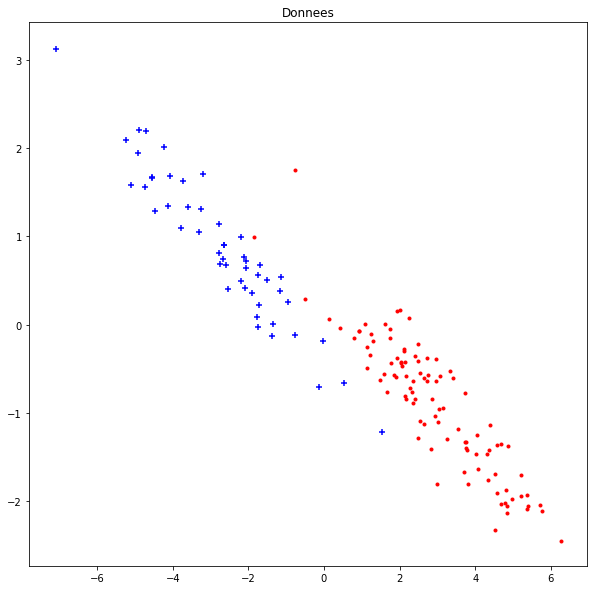

In [12]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.ion()
plt.figure(figsize=(10,10))
plot_data(x,y)
plt.title('Donnees')


# Linear Regression

In [23]:
lin = LinearRegression()
lin.fit(x,y)
y_pred = lin.predict(x)

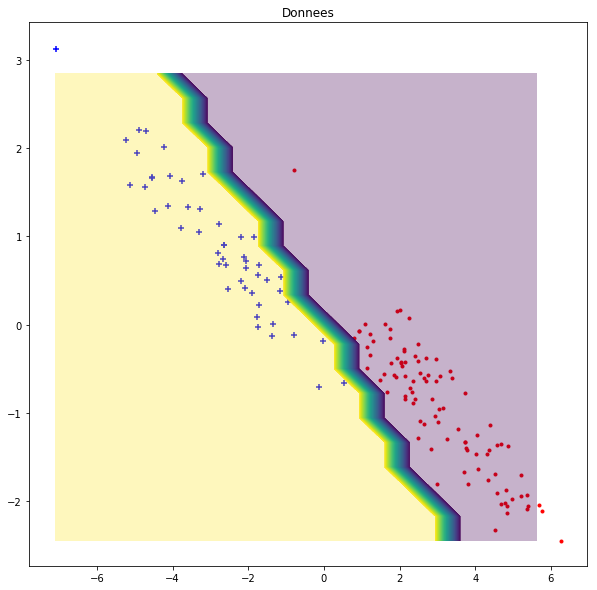

In [33]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(10,10))
plot_data(x,y_pred)
plt.title('Donnees')
plot_frontiere(x,lin.predict, alpha_c=0.3)